# Mini Project 1

**Author**: 
Doukouré Binta 
...

**Date**:

### Citation and Resources:
*Please include the citations for all tools, software, and publications referenced in the workflow. If you are basing your workflow on another previously published example notebook, please cite the name and DOI.*

#### Tools included in this workflow
*Cite the tools based on their preferred method (example through a Zenodo DOI or a publication)*

#### Workflows this work is based on (if applicable)
*If you started from another published workflow, please cite it here*

#### Publications
*Any publication that helped you build your example should be cited here*

#### Educational resources
*Any educational resource (for example Andy's Brain Book, FSL tutorials...) should be cited here.*

#### Dataset
Human Connectome project 

## Table of content
[1. Data Preparation](#1.-Data-Preparation)  
[2. Analysis](#2.-Analysis)  
[3. Results](#3.-Results) 


## Load software tools and import python libraries

In [ ]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri


import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

In [15]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

13:11:56: Debug: Adding duplicate image handler for 'Windows bitmap file'
13:11:56: Debug: Adding duplicate animation handler for '1' type
13:11:56: Debug: Adding duplicate animation handler for '2' type
13:11:57: Debug: Adding duplicate image handler for 'Windows bitmap file'
13:11:57: Debug: Adding duplicate animation handler for '1' type
13:11:57: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:413): Gtk-CRITICAL **: 13:11:57.608: gtk_window_resize: assertion 'height > 0' failed
13:11:58: Debug: ScreenToClient cannot work when toplevel window is not shown
13:11:58: Debug: ScreenToClient cannot work when toplevel window is not shown
13:11:58: Debug: ScreenToClient cannot work when toplevel window is not shown
13:11:58: Debug: ScreenToClient cannot work when toplevel window is not shown
13:11:58: Debug: ScreenToClient cannot work when toplevel window is not shown
13:11:58: Debug: ScreenToClient cannot work when toplevel window is not shown
13:11:58: Debu

## 1. Data Preparation

### Dataload

In [25]:
subject_T1 = "drive-download-20251016T123238Z-1-001/T1w/T1w.nii.gz"
# Vizualize subject 
fsleyesDisplay.load(subject_T1)

In [26]:
print_dir_tree("drive-download-20251016T123238Z-1-001")

|drive-download-20251016T123238Z-1-001/
|--- dataset_description.md
|--- task-motor_bold.json
|--- .ipynb_checkpoints/
|--- T1w/
|------ T1w.nii.gz
|--- fMRI/
|------ tfMRI_MOTOR_LR/
|--------- events_LR.csv
|--------- tfMRI_MOTOR_LR.nii
|------ tfMRI_MOTOR_RL/
|--------- events_RL.csv
|--------- tfMRI_MOTOR_RL.nii


In [27]:
subject_id = "101410"
bids_root = "drive-download-20251016T123238Z-1-001"
mkdir_no_exist(bids_root)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

###################
# Create folders relevant for preprocessing.
# In BIDs, ANYTHING we modify must go in the derivatives folder, to keep original files clean in case we make a mistake.
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-101410'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'func'))

In [35]:
print_dir_tree(bids_root)

|drive-download-20251016T123238Z-1-001/
|--- dataset_description.md
|--- task-motor_bold.json
|--- .ipynb_checkpoints/
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|--------------- T1w.nii.gz
|--------------- T1w_mask.nii.gz
|------------ func/
|--- fMRI/
|------ tfMRI_MOTOR_LR/
|--------- events_LR.csv
|--------- tfMRI_MOTOR_LR.nii
|------ tfMRI_MOTOR_RL/
|--------- events_RL.csv
|--------- tfMRI_MOTOR_RL.nii


### Structural Preprocessing

#### Skull Stripping

In [36]:
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite
    It assumes data to be in the BIDS format (which we will cover in the following weeks).
    The method also saves the brain mask which was used to extract the brain.

    The brain extraction is conducted only on the T1w of the participant.

    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    subject = 'sub-{}'.format(subject_id)
    anatomical_path = op.join(bids_root, 'T1w', 'T1w.nii.gz'.format(subject_id))
    betted_brain_path = op.join(preproc_root, subject, 'anat', 'T1w'.format(subject_id))
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, 'sub-101410', 'anat', 'T1w_mask')
get_skull_stripped_anatomical(bids_root, preproc_root, "101410")

Done with BET.


In [38]:
# Vizualize mask 
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'T1w', 'T1w.nii.gz'))
fsleyesDisplay.load(resulting_mask_path)

In [40]:
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    

anatomical_path = op.join(bids_root, 'T1w', 'T1w.nii.gz') # The original brain
betted_brain_path = op.join(preproc_root, 'sub-101410', 'anat', 'T1w.nii.gz') # The brain without skull is in the derivatives folderRGe
resulting_mask_path = op.join(preproc_root, 'sub-101410', 'anat', 'T1w_mask.nii.gz') # The mask to use

apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [44]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)

#### Segmentation 

In [67]:
fast_target = betted_brain_path #

[os.remove(f) for f in glob.glob(op.join(preproc_root, 'sub-101410', 'anat', '*fast*'))] # Just to clean the directory in between runs of the cell
segmentation_path = op.join(preproc_root, 'sub-101410', 'anat', 'T1w_fast')
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

{}

In [68]:
print_dir_tree(bids_root, max_depth=5)

|drive-download-20251016T123238Z-1-001/
|--- dataset_description.md
|--- task-motor_bold.json
|--- .ipynb_checkpoints/
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|--------------- T1w.nii.gz
|--------------- T1w_fast_mixeltype.nii.gz
|--------------- T1w_fast_pve_0.nii.gz
|--------------- T1w_fast_pve_1.nii.gz
|--------------- T1w_fast_pve_2.nii.gz
|--------------- T1w_fast_pveseg.nii.gz
|--------------- T1w_fast_seg.nii.gz
|--------------- T1w_mask.nii.gz
|------------ func/
|--------------- tfMRI_MOTOR.nii
|--------------- tfMRI_MOTOR.nii.gz
|--- fMRI/
|------ tfMRI_MOTOR_LR/
|--------- events_LR.csv
|--------- tfMRI_MOTOR_LR.nii
|--------- .ipynb_checkpoints/
|------------ events_LR-checkpoint.csv
|------ tfMRI_MOTOR_RL/
|--------- events_RL.csv
|--------- tfMRI_MOTOR_RL.nii
|--------- .ipynb_checkpoints/
|------------ events_RL-checkpoint.csv


In [70]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-101410', 'anat','*pve_0*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-101410', 'anat','*pve_1*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-101410', 'anat','*pve_2*'))[0])
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'

### Funtional preprocessing 

In [59]:
#### Concatenate runs of interest
import nibabel as nib 
from nilearn.image import concat_imgs 

LR_run_path = op.join(bids_root, 'fMRI', 'tfMRI_MOTOR_RL', 'tfMRI_MOTOR_RL.nii')
RL_run_path = op.join(bids_root, 'fMRI', 'tfMRI_MOTOR_LR', 'tfMRI_MOTOR_LR.nii')

LR_img = nib.load(LR_run_path)
RL_img = nib.load(RL_run_path)
print(LR_img.shape)

concatenated_run = concat_imgs([LR_img, RL_img])
print(concatenated_run.shape)

(91, 109, 91, 284)
(91, 109, 91, 568)


In [96]:
df_events_LR = pd.read_csv(op.join(bids_root, 'fMRI', 'tfMRI_MOTOR_RL', 'events_RL.csv'))
df_events_RL = pd.read_csv(op.join(bids_root, 'fMRI', 'tfMRI_MOTOR_LR', 'events_LR.csv'))
# CSV Concatenation 
df_events_RL['onset'] = df_events_RL['onset'] + df_events_RL['onset'][len(df_events_RL)-1] + df_events_RL['duration'][len(df_events_RL)-1]

df_events = pd.concat([df_events_LR, df_events_RL], axis = 0).reset_index()
df_events.to_csv(op.join(preproc_root, 'sub-101410', 'func', 'events.csv'))

In [97]:
# Save the image
nib.save(concatenated_run, op.join(preproc_root, 'sub-101410', 'func', 'tfMRI_MOTOR.nii'))

In [98]:
print_dir_tree(bids_root)

|drive-download-20251016T123238Z-1-001/
|--- dataset_description.md
|--- task-motor_bold.json
|--- .ipynb_checkpoints/
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|--------------- T1w.nii.gz
|--------------- T1w_fast_mixeltype.nii.gz
|--------------- T1w_fast_pve_0.nii.gz
|--------------- T1w_fast_pve_1.nii.gz
|--------------- T1w_fast_pve_2.nii.gz
|--------------- T1w_fast_pveseg.nii.gz
|--------------- T1w_fast_seg.nii.gz
|--------------- T1w_mask.nii.gz
|------------ func/
|--------------- events.csv
|--------------- tfMRI_MOTOR.nii
|--------------- tfMRI_MOTOR.nii.gz
|--------------- tfMRI_MOTOR_moco.nii.gz
|--------------- tfMRI_MOTOR_moco.nii.gz_smoothed-6mm.nii.gz
|--------------- tfMRI_MOTOR_moco.nii.par
|--------------- tfMRI_MOTOR_moco.nii.mat/
|------------------ MAT_0000
|------------------ MAT_0001
|------------------ MAT_0002
|------------------ MAT_0003
|------------------ MAT_0004
|----------------

#### Motion correction 

In [71]:
from fsl.wrappers import mcflirt

path_original_data = op.join(preproc_root, 'sub-101410', 'func', 'tfMRI_MOTOR.nii')
path_moco_data = op.join(preproc_root, 'sub-101410', 'func', 'tfMRI_MOTOR_moco.nii')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as drive-download-20251016T123238Z-1-001/derivatives/preprocessed_data/sub-101410/func/tfMRI_MOTOR_moco.nii

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [284] to 8 mm pixels
Registering volumes ... [285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][418][419][420][

refnum = 284
Original_refvol = -1


Registering volumes ... [285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][418][419][420][421][422][423][424][425][426][427][428][429][430][431][432][433][434][435][436][437][438][439][440][441][442][443][444][445][446][447][448][449][450][451][452][453][454][455][456][457][458][459][460][461][462][463][464][465][466][467][468][469][470][471][472][473][474][475][476][477][478][479][

{}

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_original_data)
fsleyesDisplay.load(op.join(preproc_root, 'sub-101410', 'func', 'tfMRI_MOTOR_moco.nii.gz'))

In [ ]:
# MOCO parameters 

In [106]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-101410', 'func', 'tfMRI_MOTOR_moco.nii.par'))
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,0.002303,0.005719,0.002596,0.345932,-0.204831,0.039974
1,0.002186,0.005927,0.002421,0.344905,-0.200448,0.046851
2,0.002081,0.005720,0.002445,0.329972,-0.210190,0.024426
3,0.002134,0.005648,0.002369,0.330662,-0.195861,0.056815
4,0.002192,0.005881,0.002359,0.322182,-0.192393,0.053530
...,...,...,...,...,...,...
563,0.000700,-0.001214,0.000311,-0.088193,-0.125097,0.083381
564,0.000858,-0.001660,0.000327,-0.104640,-0.119783,0.087627
565,0.000782,-0.001214,0.000173,-0.087827,-0.121572,0.086281
566,0.000700,-0.001214,0.000173,-0.089133,-0.131954,0.085975


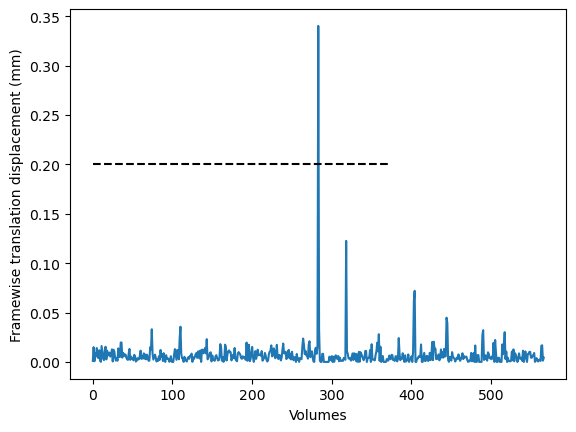

In [108]:
import matplotlib.pyplot as plt 

# Getting the translation is easy
trans_x = mot_params["Translation x"]
# Now, we want a 0.2mm with respect to previous frame:
disp_x = np.diff(trans_x)
# Lastly, we can ask for displacements (in absolute value) above 0.2mm and plot it to be clear:
threshold=0.2
plt.plot(np.abs(disp_x))
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.show()

In [110]:
# Gaussian Smoothing 
input_path = op.join(preproc_root, 'sub-101410', 'func', 'tfMRI_MOTOR_moco.nii.gz')
output_path = op.join(preproc_root, 'sub-101410', 'func', 'tfMRI_MOTOR_moco_smooth.nii.gz')
cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
subprocess.run(['fslmaths',output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])

Image Exception : #63 :: No image files match: drive-download-20251016T123238Z-1-001/derivatives/preprocessed_data/sub-101410/func/tfMRI_MOTOR_moco_smooth
terminate called after throwing an instance of 'std::runtime_error'
  what():  No image files match: drive-download-20251016T123238Z-1-001/derivatives/preprocessed_data/sub-101410/func/tfMRI_MOTOR_moco_smooth
/cvmfs/neurodesk.ardc.edu.au/containers/fsl_6.0.7.4_20231005/fslmaths: line 3: 15945 Aborted                 (core dumped) singularity --silent exec $neurodesk_singularity_opts --pwd "$PWD" /cvmfs/neurodesk.ardc.edu.au/containers/fsl_6.0.7.4_20231005/fsl_6.0.7.4_20231005.simg fslmaths "$@"


CompletedProcess(args=['fslmaths', 'drive-download-20251016T123238Z-1-001/derivatives/preprocessed_data/sub-101410/func/tfMRI_MOTOR_moco_smooth.nii.gz', '-s', '2.547987090198743', 'drive-download-20251016T123238Z-1-001/derivatives/preprocessed_data/sub-101410/func/tfMRI_MOTOR_moco_smooth.nii.gz_smoothed-6mm'], returncode=134)

In [111]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_original_data)
fsleyesDisplay.load(output_path)

PathError: Could not find a supported file with prefix "/home/jovyan/Labs/drive-download-20251016T123238Z-1-001/derivatives/preprocessed_data/sub-101410/func/tfMRI_MOTOR_moco_smooth.nii.gz"